In [1]:
import gym
import numpy as np
from dueling_ddqn_torch import Agent
from utils import plotLearning
from utils import smoothen
from gym.core import ObservationWrapper
from gym.spaces import Box
from draw_animation import drawAnimation
import torch.nn as nn
import os
import matplotlib.pyplot as plt


def get_rand(min, max):
    return np.random.uniform(np.deg2rad(min), np.deg2rad(max))


def get_rand_ini():
    return {"r_euler": [0, get_rand(0, 0), 0],
            "t_euler": [0, get_rand(-90, 90), 0]}


def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func

    return decorate


@static_vars(ini_list=np.empty(0))
def reset_params(count=10000):
    try:
        ini = reset_params.ini_list[0]
    except IndexError:
        reset_params.ini_list = np.hstack([reset_params.ini_list, [get_rand_ini() for _ in range(count)]])
        ini = reset_params.ini_list[0]

    reset_params.ini_list = np.delete(reset_params.ini_list, 0)
    return ini


class PreprocessiObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.angle_values = [3, 4, 5, 29, 30, 31]
        self.coordinates_values = [0, 1, 2, 26, 27, 28]
        self.overloads = [7, 8, 9, 10, 11]  # 10,11 for navigation Ny, Nz (last values?)
        self.speed = [6, 32]  # 15, 16, 17 target speed projections
        self.distance = [22]
        self.for_overload = [23, 24]
        self.angle_to_target = [25]
        self.target_speed = [15, 16, 17]

        self.min_coor = -5000
        self.max_coor = 20000
        self.state_size = (1, self.observation(self.env.get_obs).shape[0])
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=self.state_size)
        self.framebuffer = np.zeros(self.state_size[1], 'float32')

    def observation(self, obs):
        new_obs = np.empty(0)
        for i, elem in enumerate(obs):
            if i in self.coordinates_values:
                elem = np.round(elem, 0) / 1000
                # elem = np.round((elem - self.min_coor)/(self.max_coor - self.min_coor), 5)
            elif i in self.overloads:
                continue
                elem = np.round(elem, 2)
            elif i in self.angle_values:
                elem = np.hstack([elem, np.round(np.array(self.transform_to_trigonometry(elem)), 4)])
            elif i in self.speed:
                elem = np.round(elem) / 1000
            elif i in self.distance:
                continue
                elem = np.round(elem, 0) / 1000
            elif i in self.angle_to_target:
                elem = np.round(elem, 3)
            elif i in self.target_speed:
                continue
                elem = elem / 1000
            elif i in self.for_overload:
                if i != 24:
                    elem = np.round(elem, 4)
                else:
                    continue
            else:
                continue

            new_obs = np.hstack((new_obs, elem))  # Add embedings for manouver

        return new_obs.astype('float32')

    def transform_to_trigonometry(self, angle):
        return [np.sin(angle), np.cos(angle)]

    def reset(self, **info):
        return self.observation(self.env.reset(**info))
        # self.framebuffer = np.concatenate()


def play(env, agent, expert=False, exp_distance=2000):
    score = 0
    steps = 0
    done = False
    observation = env.reset(**reset_params())

    while not done:
        steps += 1
        if env.wrap.distance_to_target < 2000 or expert:
            env.wrap.rocket.grav_compensate()
            overload = env.wrap.rocket.proportionalCoefficients(k_z=5, k_y=5)

            possible = env.wrap.findClosestFromLegal(overload)
            action = env.wrap.overloadsToNumber([possible])[0]
        else:
            action = agent.choose_action(observation)

        observation_, reward, done, info = env.step(action)
        score += reward

        observation = observation_

    return score, steps, info


def writeGameToFile(env, agent, init, expert=False):
    score = 0

    observations = []
    done = False
    observation = env.reset(**reset_params())  # init)
    observations.append(observation)

    while not done:
        action = agent.choose_action(observation)

        if expert:
            env.wrap.rocket.grav_compensate()
            overload = env.wrap.rocket.proportionalCoefficients(k_z=5, k_y=5)
            # print(overload)

            possible = env.wrap.findClosestFromLegal(overload)
            action = env.wrap.overloadsToNumber([possible])[0]

        observation_, reward, done, info = env.step(action)
        print(info)
        score += reward
        agent.store_transition(observation, action,
                               reward, observation_, int(done))
        agent.learn()

        observation = observation_
        observations.append(observation)

    print(score)
    observations = np.array(observations)
    rocket_coor = observations[:, 0:3] * 1000
    la_coor = observations[:, 15:18] * 1000

    np.savetxt("0.csv", rocket_coor[:, [2, 0, 1]], delimiter=",")
    np.savetxt("1.csv", la_coor[:, [2, 0, 1]], delimiter=",")
    return score


In [2]:
rocket_info = [np.array([0, 0, 0]), 900, np.deg2rad([0, 0, 0])]
target_info = [np.array([18000, 0, 0]), 200, np.deg2rad([0, 0, 0])]

env = gym.make('missile_env:missile-env-v0', rocket_info=rocket_info,
               target_info=target_info)

env.seed(seed=42)
env = PreprocessiObs(env)
num_games = 50000
load_checkpoint = False

state_shape = env.observation_space.shape[1]
n_actions = env.action_space.n

save_dir = "new_version_3l_aero"

agent = Agent(gamma=0.99, epsilon=1, lr=1e-5,
              input_dims=[state_shape], n_actions=n_actions, mem_size=3*10 ** 4, eps_min=0.1,
              batch_size=256, eps_dec=3*1e-5, replace=1000,
              chkpt_dir=save_dir)

if load_checkpoint:
    agent.load_models(f"new_version/12000")

filename = f"{save_dir}/log.png"
scores = []
eps_history = []
loss_history = []
n_steps = 0

init


In [3]:
agent.load_models(f"new_version_3l/7500")

... loading checkpoint ...
... loading checkpoint ...


In [4]:
writeGameToFile(env, agent, _)

{'Destroyed': False, 'Distance': 17926.528826601727}
{'Destroyed': False, 'Distance': 17853.10755551005}
{'Destroyed': False, 'Distance': 17779.737292046786}
{'Destroyed': False, 'Distance': 17706.416325154383}
{'Destroyed': False, 'Distance': 17633.143653184703}
{'Destroyed': False, 'Distance': 17559.91935825827}
{'Destroyed': False, 'Distance': 17486.7382117616}
{'Destroyed': False, 'Distance': 17413.61391697422}
{'Destroyed': False, 'Distance': 17340.537876824637}
{'Destroyed': False, 'Distance': 17267.50923598033}
{'Destroyed': False, 'Distance': 17194.557052146523}
{'Destroyed': False, 'Distance': 17121.65461925078}
{'Destroyed': False, 'Distance': 17048.792349558014}
{'Destroyed': False, 'Distance': 16975.986526500394}
{'Destroyed': False, 'Distance': 16903.2344378642}
{'Destroyed': False, 'Distance': 16830.518636707977}
{'Destroyed': False, 'Distance': 16757.85607528302}
{'Destroyed': False, 'Distance': 16685.24535799204}
{'Destroyed': False, 'Distance': 16612.685593292565}
{'De

/Users/evgeny/Documents/Инст/Мага/Diploma/Youtube-Code-Repository/ReinforcementLearning/customEnv/dueling_ddqn_torch.py:197: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/native/IndexingUtils.h:25.)
  q_next[dones] = 0.0
/Users/evgeny/miniconda3/envs/Modern/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/native/IndexingUtils.h:25.)
  allow_unreachable=True)  # allow_unreachable flag


-5.178869783919781

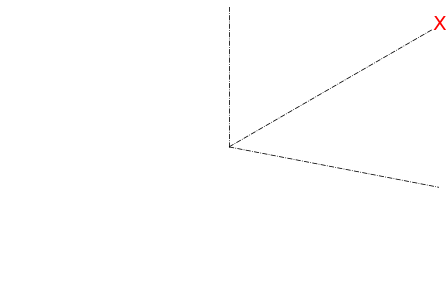